In [1]:
!pip install virtualenv

In [2]:
!virtualenv venv

created virtual environment CPython3.9.13.final.0-64 in 944ms
  creator CPython3Windows(dest=C:\Users\kotyk\venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=C:\Users\kotyk\AppData\Local\pypa\virtualenv)
    added seed packages: pip==23.1.2, setuptools==67.7.2, wheel==0.40.0
  activators BashActivator,BatchActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [3]:
from virtualenv import cli_run

cli_run(["venv"])

Выполните задание по ссылке и оформите в виде CRISP-DM подхода.

Структурируйте код, отчёт и файлы с данными на основе сегодняшней лекции.
Загрузите решение в Git и пришлите ссылку на ваш репозиторий.

Дополнительное задание*
Попробуйте не загружать CSV-файл с данными, а сделайте отдельный скрипт на его получение.

# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина

## 1.2 Описание
Информация о наборе данных:


Эти два набора данных относятся к красному и белому вариантам португальского вина «Винью Верде». Из-за проблем с конфиденциальностью и логистикой доступны только физико-химические (входные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин больше, чем отличных или плохих). Алгоритмы обнаружения выбросов могут быть использованы для обнаружения нескольких отличных или плохих вин. Кроме того, мы не уверены, что все входные переменные релевантны. Поэтому было бы интересно протестировать методы выбора признаков.

Два набора данных были объединены, и несколько значений были случайным образом удалены.




# 2. Data Understanding

## 2.1 Import Libraries

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [5]:
 pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 2.2 Вспомогательные функции

In [6]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [7]:
data = pd.read_csv("Data\winequalityN.csv")
data.shape

(6497, 13)

## 2.4 Статистика и визуализации

In [8]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [9]:
data.quality.unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

**Описание переменных**

1 - тип вина (белое или красное)

2 - фиксированная кислотность

3 - летучая кислотность

4 - лимонная кислота

5 - остаточный сахар

6 - хлориды 

7 - свободный диоксид серы

8 - общий диоксид серы

9 - плотность

10 - рН

11 - сульфаты

12 - спирт

Выходная переменная
(на основе сенсорных данных):

13 - качество (оценка от 0 до 10)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип вина.


In [10]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [12]:
describe_more(data)

,Variable,Levels,Datatype
0,type,2,object
12,quality,7,int64
3,citric acid,89,float64
1,fixed acidity,106,float64
9,pH,108,float64
10,sulphates,111,float64
11,alcohol,111,float64
6,free sulfur dioxide,135,float64
2,volatile acidity,187,float64
5,chlorides,214,float64


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

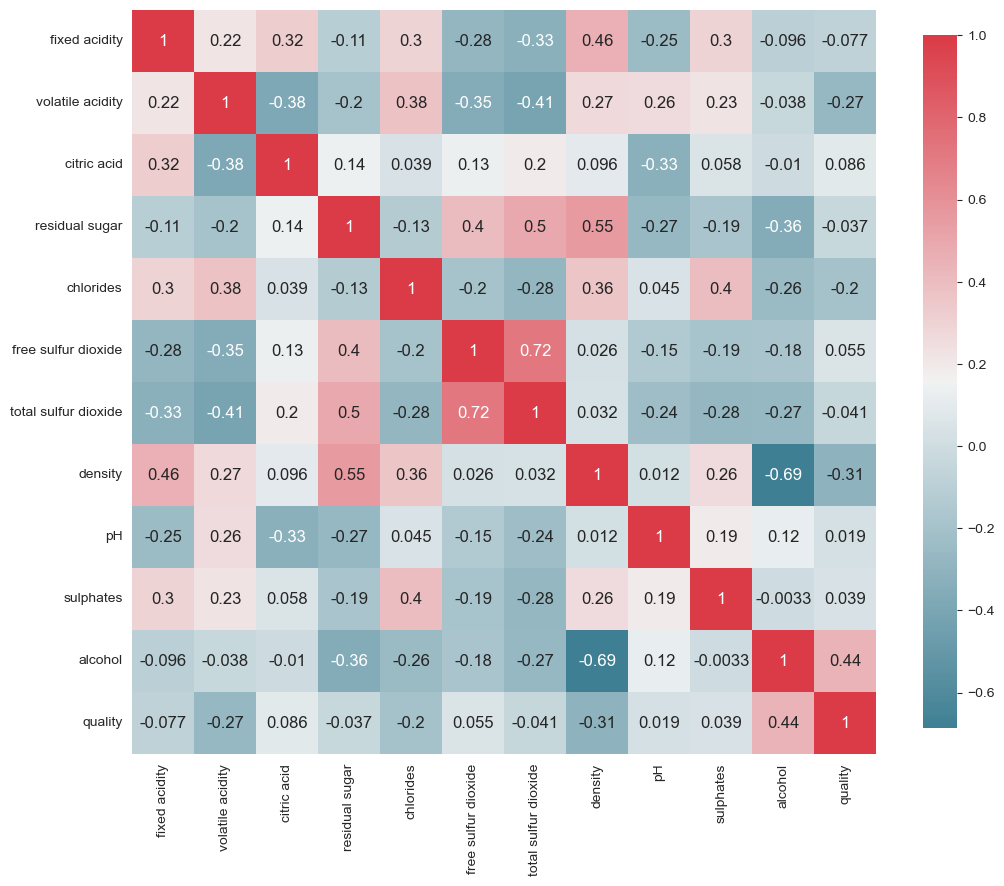

In [13]:
plot_correlation_map(data)

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и качеством вина
Начнем с рассмотрения взаимосвязи между содержанием спирта и качеством.

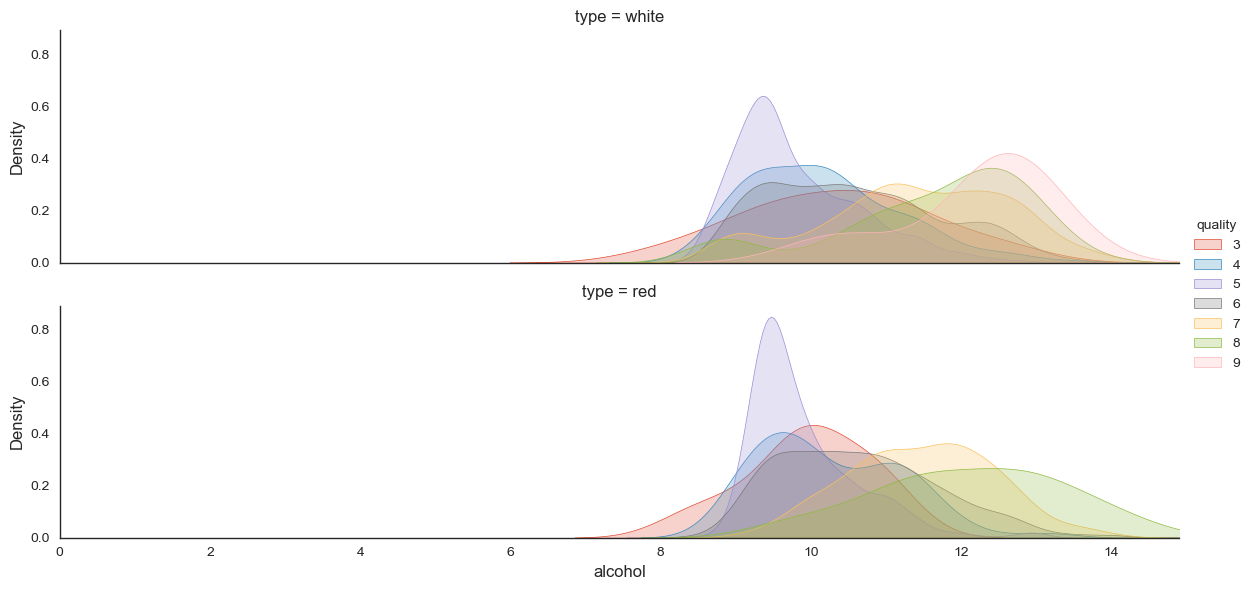

In [14]:
plot_distribution( data , var = 'alcohol' , target = 'quality' , row = 'type' )

Рассмотрим взаимосвязь между содержанием сахара и качеством.

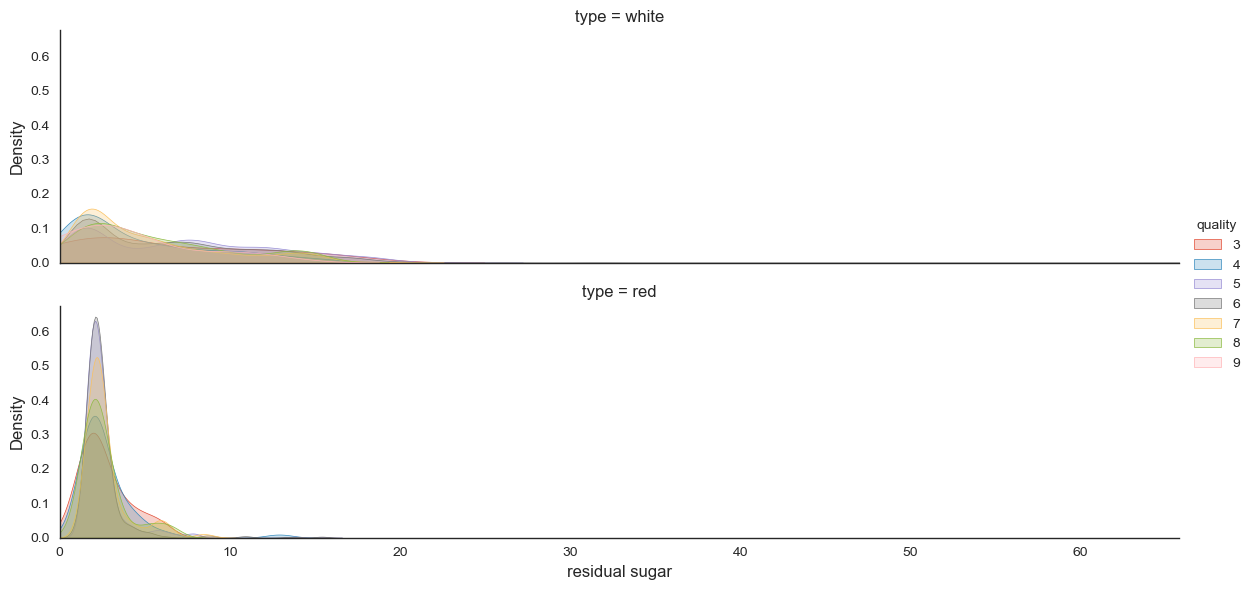

In [15]:
plot_distribution( data , var = 'residual sugar' , target = 'quality' , row = 'type' )


Рассмотрим графики выше. Различия между выживаемостью для разных значений - это то, что будет использоваться для разделения целевой переменной (в данном случае - выживаемости) в модели. Если бы две линии были примерно одинаковыми, то это не было бы хорошей переменной для нашей прогностической модели.

### 2.4.4 Тип вина
Мы также можем посмотреть на категориальную переменную - тип вина и ее связь с оценкой

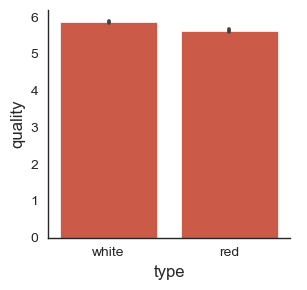

In [16]:
# Plot quality rate by type
plot_categories( data , cat = 'type' , target = 'quality' )

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменные Embarked, Pclass и Sex рассматриваются как категориальные переменные. Некоторые из  алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [17]:
# Transform type into binary values 0 and 1
color = pd.Series( np.where( data['type'] == 'red' , 1 , 0 ) , name = 'color' )

## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [18]:
df = pd.DataFrame()
for i in data.loc[:, data.columns !='type']:
  df[i] = data[i].groupby(data['type']).fillna(data[i].mean())

In [19]:
df = df.drop(['total sulfur dioxide', 'quality'], axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 6496
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fixed acidity        6497 non-null   float64
 1   volatile acidity     6497 non-null   float64
 2   citric acid          6497 non-null   float64
 3   residual sugar       6497 non-null   float64
 4   chlorides            6497 non-null   float64
 5   free sulfur dioxide  6497 non-null   float64
 6   density              6497 non-null   float64
 7   pH                   6497 non-null   float64
 8   sulphates            6497 non-null   float64
 9   alcohol              6497 non-null   float64
dtypes: float64(10)
memory usage: 816.4 KB


## 3.3 Feature Engineering &ndash; добавляем новые признаки


**На основе признака - содержания сахара - создадим новые признаки:**

Сухие натуральные вина (до 5 г/л).

Полусухие вина (от 5 до 30 г/л).

Полусладкие вина (от 30 до 80 г/л).

Сладкое (от 80 г/л).





In [21]:
def sugar(x):
  if x < 5:
    return 'dry'
  elif x >= 5 and x < 30:
    return 'semi-dry'
  elif x >= 30 and x < 80:
    return 'semi-sweet'
  else:
    return 'sweet'   

In [22]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = data['residual sugar'].apply(sugar)

In [23]:
title

,Title
0,semi-dry
1,dry
2,semi-dry
3,semi-dry
4,semi-dry
...,...
6492,dry
6493,dry
6494,dry
6495,dry


In [24]:
title = pd.get_dummies( title.Title )
title.head()

,dry,semi-dry,semi-sweet,sweet
0,0,1,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [25]:
data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Variable selection
Выбираем признаки для формирования итогового датасет.



In [26]:
full_X = pd.concat( [ df , title , color ] , axis=1 )
full_X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,dry,semi-dry,semi-sweet,sweet,color
0,7.0,0.27,0.36,20.7,0.045,45.0,1.0010,3.00,0.45,8.8,0,1,0,0,0
1,6.3,0.30,0.34,1.6,0.049,14.0,0.9940,3.30,0.49,9.5,1,0,0,0,0
2,8.1,0.28,0.40,6.9,0.050,30.0,0.9951,3.26,0.44,10.1,0,1,0,0,0
3,7.2,0.23,0.32,8.5,0.058,47.0,0.9956,3.19,0.40,9.9,0,1,0,0,0
4,7.2,0.23,0.32,8.5,0.058,47.0,0.9956,3.19,0.40,9.9,0,1,0,0,0


### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [27]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:6497 ]
train_valid_y = data.quality
test_X = full_X[:]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(6497, 15) (4547, 15) (1950, 15) (4547,) (1950,) (6497, 15)


### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


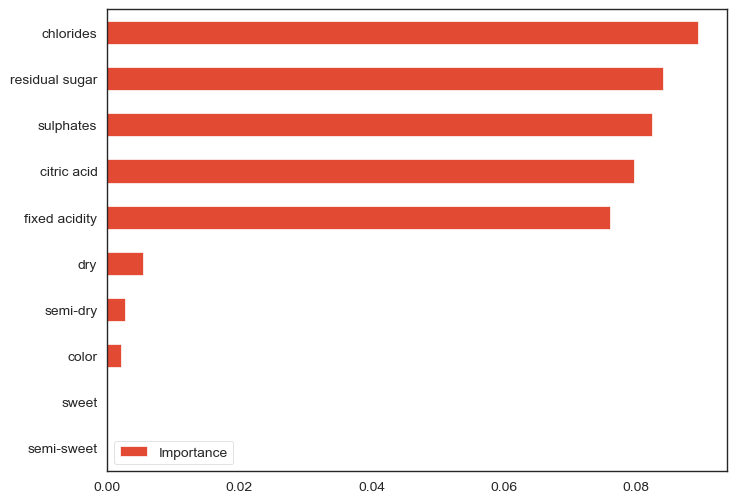

In [28]:
plot_variable_importance(train_X, train_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [29]:
model = RandomForestClassifier(max_depth = 13, random_state = 13)

## 4.2 Обучение модели

In [30]:
model.fit( train_X , train_y )

RandomForestClassifier(max_depth=13, random_state=13)

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [31]:
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.9544754783373653 0.6564102564102564


## 5.2 Сохранение модели

In [32]:
import joblib

In [33]:
filename = '1.0-NMA-RandomForestClassifier.sav'
joblib.dump(model, open(filename, 'wb'))

# 6. Развертывание

Развертывание в данном означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [34]:
test_Y = model.predict( test_X )
id = data[:6497].index
test = pd.DataFrame( { 'id': id , 'quality': test_Y } )
test.shape
test.head()
test.to_csv( 'wine_pred.csv' , index = False )